### This notebook only includes the code used to make one of our baseline models
The main modeling code can be found in "Preprocessing_Modeling" in the same folder



In [2]:
import time
import os
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import shutil
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torch.autograd import Variable
from __future__ import print_function, division

cudnn.benchmark = True
plt.ion()   # interactive mode
import torch.optim as optim
import torch.nn.functional as F


In [3]:
from torch.utils.data import ConcatDataset, Subset
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.utils.data import random_split
import math
from torchvision.datasets import ImageFolder

In [4]:
from pathlib import Path
from collections import Counter

In [12]:
from torchsummary import summary

In [5]:
data_dir = Path('../data/chest_xray')
train_dir = data_dir / 'train'
test_dir = data_dir / 'test'
val_dir = data_dir / 'val'

In [6]:
normal_path = train_dir / 'NORMAL'
pneumo_path = train_dir / 'PNEUMONIA'

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [8]:
train_data = datasets.ImageFolder(train_dir, transform = data_transforms['train'])
test_data = datasets.ImageFolder(test_dir, transform = data_transforms['test'])
val_data = datasets.ImageFolder(val_dir,transform = data_transforms['val'])

In [9]:
trainDL = DataLoader(train_data, batch_size = 16, shuffle = True, num_workers = 6,pin_memory=True)
valDL = DataLoader(val_data, batch_size = 16, shuffle = True, num_workers = 6, pin_memory = True)
testDL = DataLoader(test_data, batch_size = 16, shuffle = True, num_workers = 6, pin_memory = True)

In [10]:
dataloaders = {'train': trainDL, 'val':valDL, 'test':testDL}

In [11]:
for i, (images,labels) in enumerate(trainDL):
    if torch.cuda.is_available():
        images=Variable(images.cuda())
        labels=Variable(labels.cuda())

In [13]:
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html used as a reference

class simpleNN(nn.Module):
    def __init__(self):
        super(simpleNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5)
        self.pool = nn.MaxPool2d(kernel_size = 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*61*61, 10)
        self.fc2 = nn.Linear(10,2)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        #x = torch.flatten(x,1)
        x= x.view(-1,16*61*61)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x= x.view(-1,32*128*128)
        
        return x


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
model = simpleNN().cuda()

In [16]:
summary(model,(images.shape[1], images.shape[2], images.shape[3]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 252, 252]             456
         MaxPool2d-2          [-1, 6, 126, 126]               0
            Conv2d-3         [-1, 16, 122, 122]           2,416
         MaxPool2d-4           [-1, 16, 61, 61]               0
            Linear-5                   [-1, 10]         595,370
            Linear-6                    [-1, 2]              22
Total params: 598,264
Trainable params: 598,264
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 5.90
Params size (MB): 2.28
Estimated Total Size (MB): 8.94
----------------------------------------------------------------


In [17]:
#loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [18]:
torch.cuda.is_available()

True

In [19]:
criterion = criterion.cuda()

In [21]:
def ez_metrics(model, test_data = test_data):
    from sklearn.metrics import classification_report, f1_score
    from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

    test_load = DataLoader(test_data, batch_size = 1)
    y_pred_list = []
    y_true_list = []
    with torch.no_grad():
        for imgs, labels in test_load:
            x_batch, y_batch = imgs.to(device), labels.to(device)
            y_test_pred = model(x_batch)
            y_test_pred = torch.log_softmax(y_test_pred, dim=1)
            _, y_pred_tag = torch.max(y_test_pred, dim = 1)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            y_true_list.append(y_batch.cpu().numpy())
    y_pred_list = [i[0] for i in y_pred_list]
    y_true_list = [i[0] for i in y_true_list]
    print(classification_report(y_true_list, y_pred_list))
    print("Accuracy Score:  ", accuracy_score(y_true_list, y_pred_list))
    print("F1 Score:  ", f1_score(y_true_list, y_pred_list))
    fig, ax = plt.subplots(figsize=(8,6))
    cm = confusion_matrix(y_true_list, y_pred_list)
    disp = ConfusionMatrixDisplay(cm, display_labels = [0,1])
    disp.plot(ax=ax)  
    return y_pred_list, y_true_list

              precision    recall  f1-score   support

           0       0.95      0.45      0.61       234
           1       0.75      0.99      0.85       390

    accuracy                           0.79       624
   macro avg       0.85      0.72      0.73       624
weighted avg       0.83      0.79      0.76       624

Accuracy Score:   0.7868589743589743
F1 Score:   0.8527131782945737


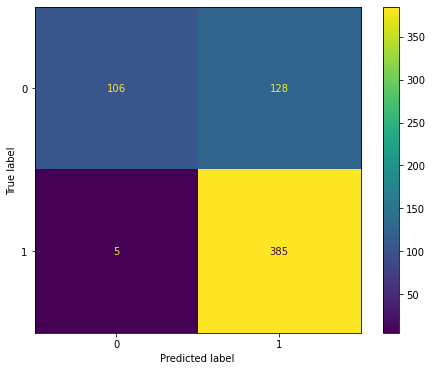

In [22]:
y_pred_list, y_true_list = ez_metrics(model, test_data)

In [155]:
model

simpleNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)

In [156]:
#torch.save(model.state_dict(), '../models/baselineCNN')

References:

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
https://www.kaggle.com/code/fahadmehfoooz/pneumonia-classification-using-pytorch